In [169]:
import kagglehub
import pandas as pd
import numpy as np


In [170]:
# Download latest version
path = kagglehub.dataset_download("shree1992/housedata")

print("Path to dataset files:", path)

Path to dataset files: C:\Users\basha\.cache\kagglehub\datasets\shree1992\housedata\versions\2


In [171]:
data = pd.read_csv(path + "/data.csv")
data.head(3)


,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,sqft_above,sqft_basement,yr_built,yr_renovated,street,city,statezip,country
0,2014-05-02 00:00:00,313000.0,3.0,1.5,1340,7912,1.5,0,0,3,1340,0,1955,2005,18810 Densmore Ave N,Shoreline,WA 98133,USA
1,2014-05-02 00:00:00,2384000.0,5.0,2.5,3650,9050,2.0,0,4,5,3370,280,1921,0,709 W Blaine St,Seattle,WA 98119,USA
2,2014-05-02 00:00:00,342000.0,3.0,2.0,1930,11947,1.0,0,0,4,1930,0,1966,0,26206-26214 143rd Ave SE,Kent,WA 98042,USA


In [172]:
data.isna().sum()

date             0
price            0
bedrooms         0
bathrooms        0
sqft_living      0
sqft_lot         0
floors           0
waterfront       0
view             0
condition        0
sqft_above       0
sqft_basement    0
yr_built         0
yr_renovated     0
street           0
city             0
statezip         0
country          0
dtype: int64

In [173]:
data.shape


(4600, 18)

In [174]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
price,4600.0,551962.988473,563834.702547,0.0,322875.00,460943.461539,654962.50,26590000.0
bedrooms,4600.0,3.400870,0.908848,0.0,3.00,3.000000,4.00,9.0
bathrooms,4600.0,2.160815,0.783781,0.0,1.75,2.250000,2.50,8.0
sqft_living,4600.0,2139.346957,963.206916,370.0,1460.00,1980.000000,2620.00,13540.0
sqft_lot,4600.0,14852.516087,35884.436145,638.0,5000.75,7683.000000,11001.25,1074218.0
floors,4600.0,1.512065,0.538288,1.0,1.00,1.500000,2.00,3.5
waterfront,4600.0,0.007174,0.084404,0.0,0.00,0.000000,0.00,1.0
view,4600.0,0.240652,0.778405,0.0,0.00,0.000000,0.00,4.0
condition,4600.0,3.451739,0.677230,1.0,3.00,3.000000,4.00,5.0
sqft_above,4600.0,1827.265435,862.168977,370.0,1190.00,1590.000000,2300.00,9410.0


In [175]:
numericData = data.select_dtypes(include="number")
numericData.head()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,sqft_above,sqft_basement,yr_built,yr_renovated
0,313000.0,3.0,1.50,1340,7912,1.5,0,0,3,1340,0,1955,2005
1,2384000.0,5.0,2.50,3650,9050,2.0,0,4,5,3370,280,1921,0
2,342000.0,3.0,2.00,1930,11947,1.0,0,0,4,1930,0,1966,0
3,420000.0,3.0,2.25,2000,8030,1.0,0,0,4,1000,1000,1963,0
4,550000.0,4.0,2.50,1940,10500,1.0,0,0,4,1140,800,1976,1992


In [176]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
import seaborn as sns
import matplotlib.pyplot as plt

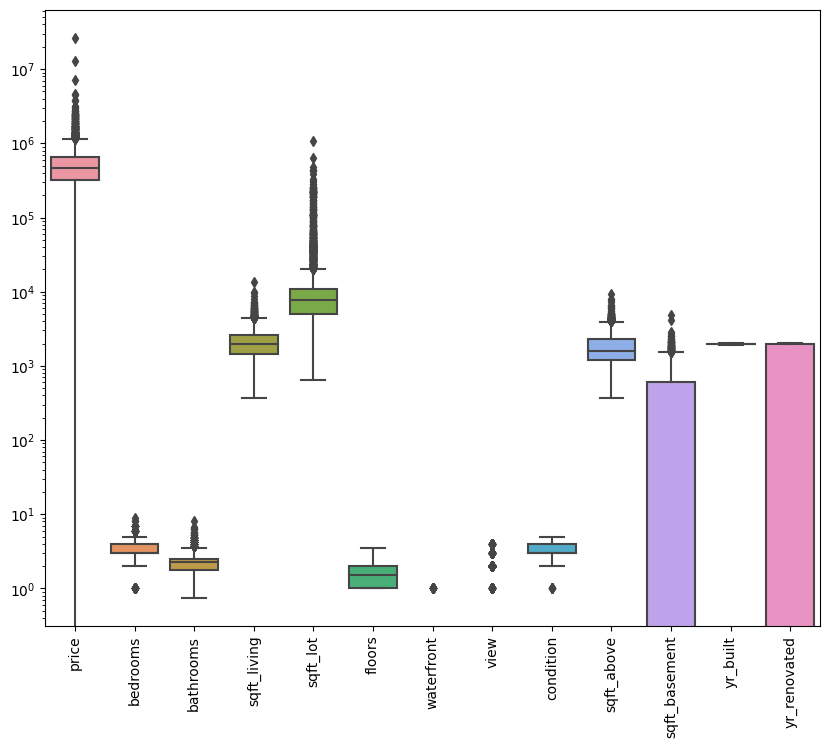

In [177]:
plt.figure(figsize=(10, 8))
sns.boxplot(data=numericData)
plt.yscale('log')
plt.xticks(rotation=90)
plt.show()

In [178]:
# Function to count outliers using IQR
def count_outliers_iqr(df):
    outlier_counts = {}
    
    for col in df.select_dtypes(include='number'):  # Only numerical columns
        Q1 = df[col].quantile(0.25)  # First quartile
        Q3 = df[col].quantile(0.75)  # Third quartile
        IQR = Q3 - Q1  # Interquartile range
        
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        
        outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)]
        outlier_counts[col] = outliers.shape[0]
    
    return outlier_counts

count_outliers_iqr(numericData)

{'price': 240,
 'bedrooms': 118,
 'bathrooms': 141,
 'sqft_living': 129,
 'sqft_lot': 541,
 'floors': 0,
 'waterfront': 33,
 'view': 460,
 'condition': 6,
 'sqft_above': 116,
 'sqft_basement': 82,
 'yr_built': 0,
 'yr_renovated': 0}

In [179]:
from scipy.stats import zscore

# Function to count outliers using Z-score
def count_outliers_zscore(df, threshold=3):
    outlier_counts = {}
    
    for col in df.select_dtypes(include='number'):
        z_scores = zscore(df[col])  # Compute Z-scores
        outliers = (abs(z_scores) > threshold).sum()  # Count values beyond threshold
        outlier_counts[col] = outliers
    
    return outlier_counts

# Count outliers using Z-score
outliers_zscore = count_outliers_zscore(numericData)
print(outliers_zscore)

{'price': 34, 'bedrooms': 19, 'bathrooms': 27, 'sqft_living': 50, 'sqft_lot': 78, 'floors': 2, 'waterfront': 33, 'view': 186, 'condition': 6, 'sqft_above': 53, 'sqft_basement': 46, 'yr_built': 0, 'yr_renovated': 0}


In [182]:
numericData = numericData.drop(["view", "waterfront"], axis=1)

In [183]:
numeric_df = numericData

# Calculate quartiles and IQR for each numeric column
Q1 = numeric_df.quantile(0.25)
Q3 = numeric_df.quantile(0.75)

IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

outliers_df = pd.DataFrame(columns=numeric_df.columns)

for col in numeric_df.columns:
    lower_outliers = numeric_df[col] < lower_bound[col]
    upper_outliers = numeric_df[col] > upper_bound[col]
    feature_outliers = numeric_df[(lower_outliers) | (upper_outliers)]
    outliers_df = pd.concat([outliers_df, feature_outliers])


print(outliers_df.duplicated().sum())
# Drop duplicates to get unique outlier samples
outliers_df = outliers_df.drop_duplicates()
print(outliers_df.duplicated().sum())

dfNoOutliers = numericData.copy()
# cappint outliers
for col in numeric_df.columns:
    lower_bound = Q1[col] - 1.5 * IQR[col]
    upper_bound = Q3[col] + 1.5 * IQR[col]
    dfNoOutliers[col] = np.clip(dfNoOutliers[col], lower_bound, upper_bound)



462
0


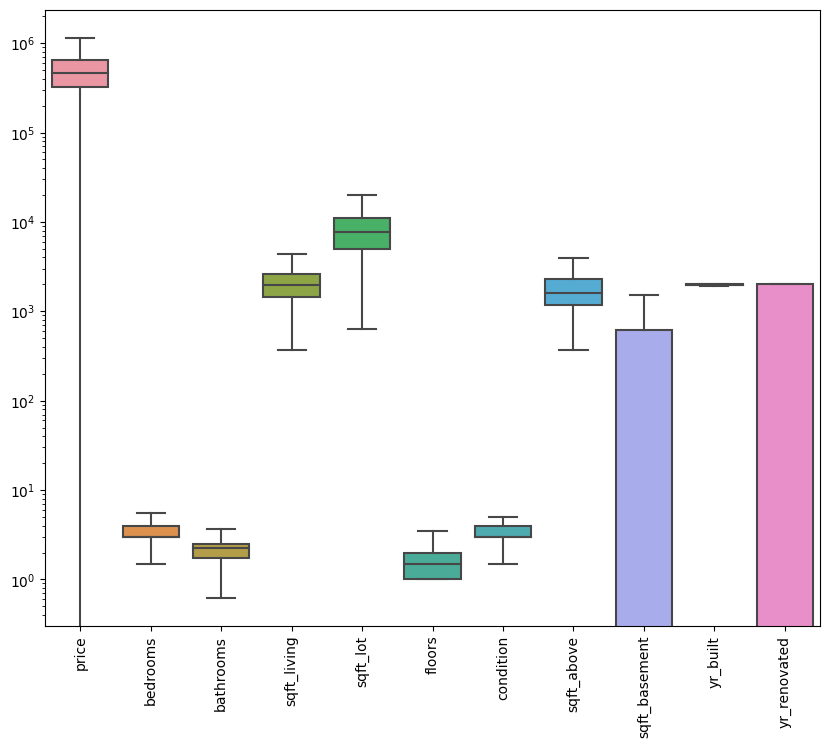

In [184]:
plt.figure(figsize=(10, 8))
sns.boxplot(data=dfNoOutliers)
plt.yscale('log')
plt.xticks(rotation=90)
plt.show()

In [185]:
numericData = dfNoOutliers

In [186]:
model = LinearRegression()

In [187]:
corr = numericData.corr()

In [188]:
numericData.describe().T

,count,mean,std,min,25%,50%,75%,max
price,4600.0,516993.305241,261471.565541,0.000,322875.00,460943.461539,654962.50,1153093.750
bedrooms,4600.0,3.392609,0.856964,1.500,3.00,3.000000,4.00,5.500
bathrooms,4600.0,2.139158,0.720548,0.625,1.75,2.250000,2.50,3.625
sqft_living,4600.0,2114.626739,867.106902,370.000,1460.00,1980.000000,2620.00,4360.000
sqft_lot,4600.0,8934.793261,5388.102126,638.000,5000.75,7683.000000,11001.25,20002.000
floors,4600.0,1.512065,0.538288,1.000,1.00,1.500000,2.00,3.500
condition,4600.0,3.452391,0.675105,1.500,3.00,3.000000,4.00,5.000
sqft_above,4600.0,1810.417826,800.648273,370.000,1190.00,1590.000000,2300.00,3965.000
sqft_basement,4600.0,305.431522,438.534107,0.000,0.00,0.000000,610.00,1525.000
yr_built,4600.0,1970.786304,29.731848,1900.000,1951.00,1976.000000,1997.00,2014.000


In [189]:
len(numericData.columns)

11

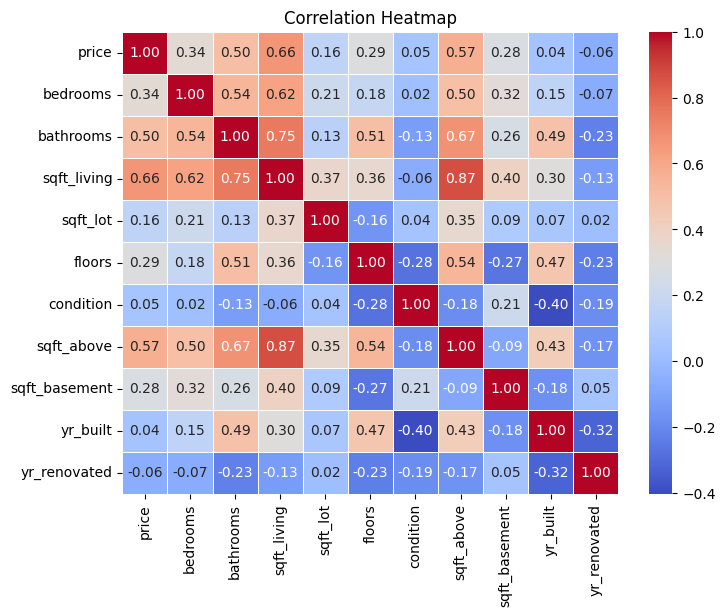

In [190]:
# Plot heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title("Correlation Heatmap")
plt.show()

In [216]:
from sklearn.preprocessing import MinMaxScaler
# Initialize scaler
scaler = MinMaxScaler()

# Scale the column (reshape to 2D array)
scaled_values = scaler.fit_transform(numericData[['sqft_living']])

# Replace the original column with scaled values
numericData['sqft_living'] = scaled_values

print(numericData[['sqft_living']])

      sqft_living
0        0.243108
1        0.822055
2        0.390977
3        0.408521
4        0.393484
...           ...
4595     0.285714
4596     0.273183
4597     0.661654
4598     0.431078
4599     0.280702

[4600 rows x 1 columns]


In [217]:
# X = numericData[["bedrooms","bathrooms","sqft_living","sqft_lot","floors","yr_built"]]
X = numericData[["sqft_living"]]
y = numericData[["price"]]


In [218]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


In [219]:
model.fit(X_train,y_train)


LinearRegression()

In [220]:
y_pred = model.predict(X)


In [221]:
print("Predicted house prices:", y_pred)


Predicted house prices: [[361733.77247976]
 [827623.83402952]
 [480727.33798381]
 ...
 [698546.06805902]
 [512996.77947643]
 [391986.37387909]]


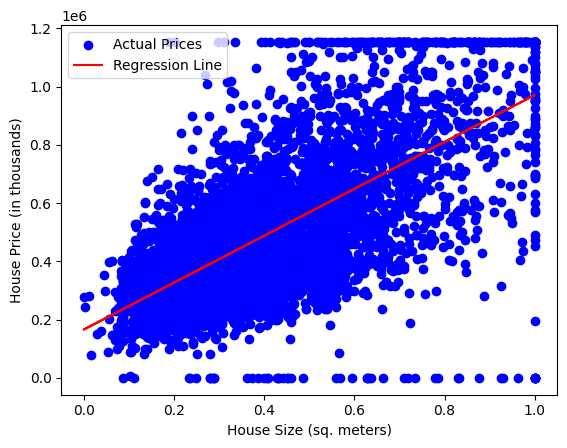

In [222]:
plt.scatter(X, y, color='blue', label="Actual Prices")
plt.plot(X, model.predict(X), color='red', label="Regression Line")
plt.xlabel("House Size (sq. meters)")
plt.ylabel("House Price (in thousands)")
plt.legend()
plt.show()

In [226]:
# Modelling
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor,AdaBoostRegressor
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression, Ridge,Lasso
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.model_selection import RandomizedSearchCV
from xgboost import XGBRegressor
from catboost import CatBoostRegressor

import warnings


models = {  
    "Linear Regression": LinearRegression(),
    "Lasso": Lasso(),
    "Ridge": Ridge(solver='lsqr'),
    "K-Neighbors Regressor": KNeighborsRegressor(),
    "Decision Tree": DecisionTreeRegressor(),
    "Random Forest Regressor": RandomForestRegressor(),
    "XGBRegressor": XGBRegressor(), 
    "CatBoosting Regressor": AdaBoostRegressor(verbose=False),
    "AdaBoost Regressor": AdaBoostRegressor()
}


TypeError: AdaBoostRegressor.__init__() got an unexpected keyword argument 'verbose'